In [1]:
import cv2
import dlib
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

from util import *

%matplotlib inline

In [2]:
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor("./dlib/shape_predictor_68_face_landmarks.dat")

In [3]:
with open('./dataset/ck.plus.pickle','rb') as f:
    ck_data, ck_label = pickle.load(f)
    
face_landmarks_train = [] 
face_label_train = []
face_landmarks_test = []
face_label_test = []

ck_data_train, ck_data_test, ck_label_train, ck_label_test = train_test_split(ck_data, np.asarray(ck_label), test_size=0.25, random_state=42)
counter = 1

for face, label in zip(ck_data_train, ck_label_train):
    face = np.array(face)
    faces = face_detector(face.reshape(128,128), 1)
    for k,d in enumerate(faces):
        shape = landmark_predictor(face.reshape(128,128), d)
        
        xlist = [float(shape.part(i).x) for i in range(68)]
        ylist = [float(shape.part(i).y) for i in range(68)]
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = xlist - xmean
        ycentral = ylist - ymean
            
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        
        face_landmarks_train.append(landmarks_vectorised)
        face_label_train.append(label)
    
for face, label in zip(ck_data_test, ck_label_test):
    face = np.array(face)
    faces = face_detector(face.reshape(128,128), 1)
    
    for k,d in enumerate(faces):
        shape = landmark_predictor(face.reshape(128,128), d)
        
        xlist = [float(shape.part(i).x) for i in range(68)]
        ylist = [float(shape.part(i).y) for i in range(68)]
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = xlist - xmean
        ycentral = ylist - ymean
        
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        
        face_landmarks_test.append(landmarks_vectorised)
        face_label_test.append(label)
        

              precision    recall  f1-score   support

           😐       0.92      0.95      0.93       323
           😠       0.89      0.91      0.90        90
           😏       0.88      0.61      0.72        23
           😷       0.98      0.92      0.95        86
           😨       0.98      0.95      0.96        42
           😀       0.98      0.99      0.99       129
           😢       0.80      0.84      0.82        44
           😱       0.99      0.97      0.98       121

   micro avg       0.94      0.94      0.94       858
   macro avg       0.93      0.89      0.91       858
weighted avg       0.94      0.94      0.94       858

Accuracy:  0.9358974358974359
Normalized confusion matrix


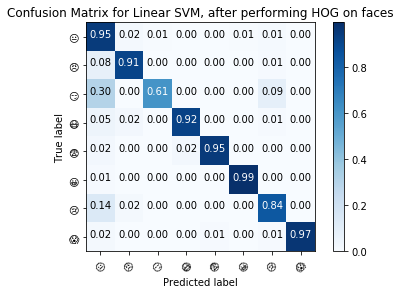

In [4]:
target_classes = get_face_label()

clf = SVC(kernel='linear', probability=True, tol=1e-3)

clf = clf.fit(face_landmarks_train, face_label_train)
ck_label_predict = clf.predict(face_landmarks_test)

print(classification_report(ck_label_test, ck_label_predict, target_names=target_classes))
print('Accuracy: ' , accuracy_score(ck_label_test, ck_label_predict))

cm = confusion_matrix(ck_label_test, ck_label_predict, labels=range(8))
plot_confusion_matrix(cm, classes=target_classes, title='Confusion Matrix for Linear SVM, after performing HOG on faces', normalize=True)